500784954 Bas Levering Recurrent Neural Network

## Clickbait title detection.
Given is a labeled dataset containing the description of an article, using text analysis we are going to classify these titles to determine if they are clickbait or not clickbait, 1 or 0. We'll be using a recurrent neural network to acomplish this.

In [18]:
# libraries

from IPython.display import display 
# math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# tensorflow
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix

In [19]:
# Import the dataset

df = pd.read_csv('../dataset/clickbait.csv')
df.head()

,headline,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1


In [20]:
# Split in train and test set.

X_train, X_val, y_train, y_val = train_test_split(df['headline'].values, df['clickbait'].values, random_state = 420)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(24000,) (8000,) (24000,) (8000,)


In [21]:
tokenizer = Tokenizer(num_words=4000)
tokenizer.fit_on_texts(df['headline'].values)

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(X_train, 420)
X_val = pad_sequences(X_val, 420)

## Setup the model

In [22]:
np.__version__

'1.19.2'

In [23]:
model = Sequential()

model.add(Embedding(4000, 32, input_length=420))
model.add(LSTM(32, return_sequences=True))

model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 420, 32)           128000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 420, 32)           8320      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 136,353
Trainable params: 136,353
Non-trainable params: 0
_________________________________________________________________


In [27]:
Early_stopping_callbacks = [
    EarlyStopping(
        monitor = 'val_accuracy',
        verbose = 1,
        patience = 3,
        min_delta = 1e-4,
    ),
    ModelCheckpoint(
        filepath='../models/model.h5',
        mode='max', 
        monitor='val_accuracy', 
        save_weights_only = True,
        save_best_only = True,
        verbose=1
    )
]

model.compile(loss='squared_hinge', optimizer='adam', metrics=['accuracy'])

hist = model.fit(X_train, y_train, batch_size = 512, validation_data = (X_val, y_val), epochs=10, callbacks = Early_stopping_callbacks)



Epoch 1/10
47/47 [==============================] - 166s 3s/step - loss: 1.0041 - accuracy: 0.5015 - val_loss: 0.9990 - val_accuracy: 0.4901

Epoch 00001: val_accuracy improved from -inf to 0.49013, saving model to ../models/model.h5
Epoch 2/10
47/47 [==============================] - 132s 3s/step - loss: 0.9980 - accuracy: 0.5021 - val_loss: 0.9703 - val_accuracy: 0.4901

Epoch 00002: val_accuracy did not improve from 0.49013
Epoch 3/10
47/47 [==============================] - 136s 3s/step - loss: 0.9430 - accuracy: 0.5099 - val_loss: 0.8538 - val_accuracy: 0.4901

Epoch 00003: val_accuracy did not improve from 0.49013
Epoch 4/10
47/47 [==============================] - 306s 7s/step - loss: 0.8057 - accuracy: 0.6606 - val_loss: 0.6874 - val_accuracy: 0.9245

Epoch 00004: val_accuracy improved from 0.49013 to 0.92450, saving model to ../models/model.h5
Epoch 5/10
47/47 [==============================] - 136s 3s/step - loss: 0.6875 - accuracy: 0.9053 - val_loss: 0.6109 - val_accuracy: 0

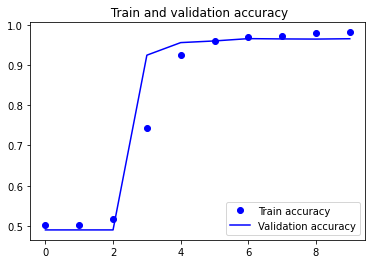

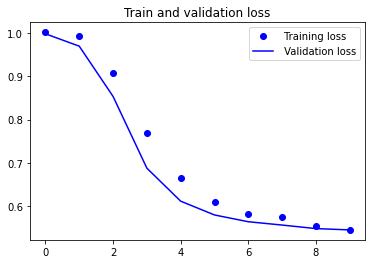

In [35]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epoch_count = range(len(acc))


plt.plot(range(len(acc)), acc, 'bo', label = 'Train accuracy')
plt.plot(range(len(acc)), val_acc, 'b', label = 'Validation accuracy')
plt.title(' Train and validation accuracy')

plt.legend()
plt.figure()

plt.plot(epoch_count, loss, 'bo', label=' Training loss')
plt.plot(epoch_count, val_loss, 'b', label=' Validation loss')
plt.title('Train and validation loss')

plt.legend()
plt.show()

## Test examples

Lets try to predict some titles, we can gather these titles from youtube or socialmedia. We can determine ourselves if its clickbaity or not. 

In [41]:
title_example_list = ["We’re Not Allowed To Talk About This", "Why everyone HATES the Miama Grand Prix", "Do you have progressive Overload anxiety?", "Elon Musk's Insane New Twitter Update Changes Everything!"]             
token_txt = pad_sequences(tokenizer.texts_to_sequences(title_example_list), maxlen = 420)
                      
predictions = [round(i[0]) for i in model.predict(token_txt)]

for (text, pred) in zip(title_example_list, predictions):
    label = 'clickbait title' if pred == 1.0 else 'non-clickbait title'
    print("{} - {}".format(text, label))


We’re Not Allowed To Talk About This - non-clickbait title
Why everyone HATES the Miama Grand Prix - clickbait title
Do you have progressive Overload anxiety? - clickbait title
Elon Musk's Insane New Twitter Update Changes Everything! - clickbait title


### Evaluation

We are doing binary classification, therefore we chose the softmax activationfunction.
